## 1. Cargar datos procesados

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
import seaborn as sns

# Cargar datos procesados
with open('datos_procesados.pkl', 'rb') as f:
    datos = pickle.load(f)

habilidades = datos['habilidades']
grupos_bge_ngram = datos['grupos_bge_ngram']
tfidf_emb_df = datos['tfidf_emb_df']
espacio_vectorial_tfidf = datos['espacio_vectorial_tfidf']
tfidf_epn_69d = datos['tfidf_epn_69d']
ofertas_por_carrera = datos['ofertas_por_carrera']

print("✓ Datos cargados correctamente")
print(f"Carreras académicas disponibles: {list(tfidf_epn_69d.columns)}")

✓ Datos cargados correctamente
Carreras académicas disponibles: ['Licenciatura Administracion De Empresas', 'Ingenieria Agroindustria', 'Ingenieria Ambiental', 'Ciencias De Datos E Inteligencia Artificial', 'Ingenieria En Ciencias De La Computacion', 'Economia', 'Ingenieria En Electricidad', 'Ingenieria En Electronica Y Automatizacion', 'Fisica', 'Ingenieria En Geologia', 'Ingenieria De La Produccion', 'Matematica', 'Matematica Aplicada', 'Ingenieria En Materiales', 'Ingenieria En Mecanica', 'Ingenieria En Mecatronica', 'Ingenieria En Petroleos', 'Ingenieria Quimica', 'Ingenieria En Sistemas De Informacion', 'Ingenieria En Software', 'Ingenieria En Telecomunicacion De La Informacion', 'Ingenieria En Telecomunicaciones', 'Ingenieria Civil', 'Seguridad De Redes De Informacion']


## 2. Visualizaciones generales

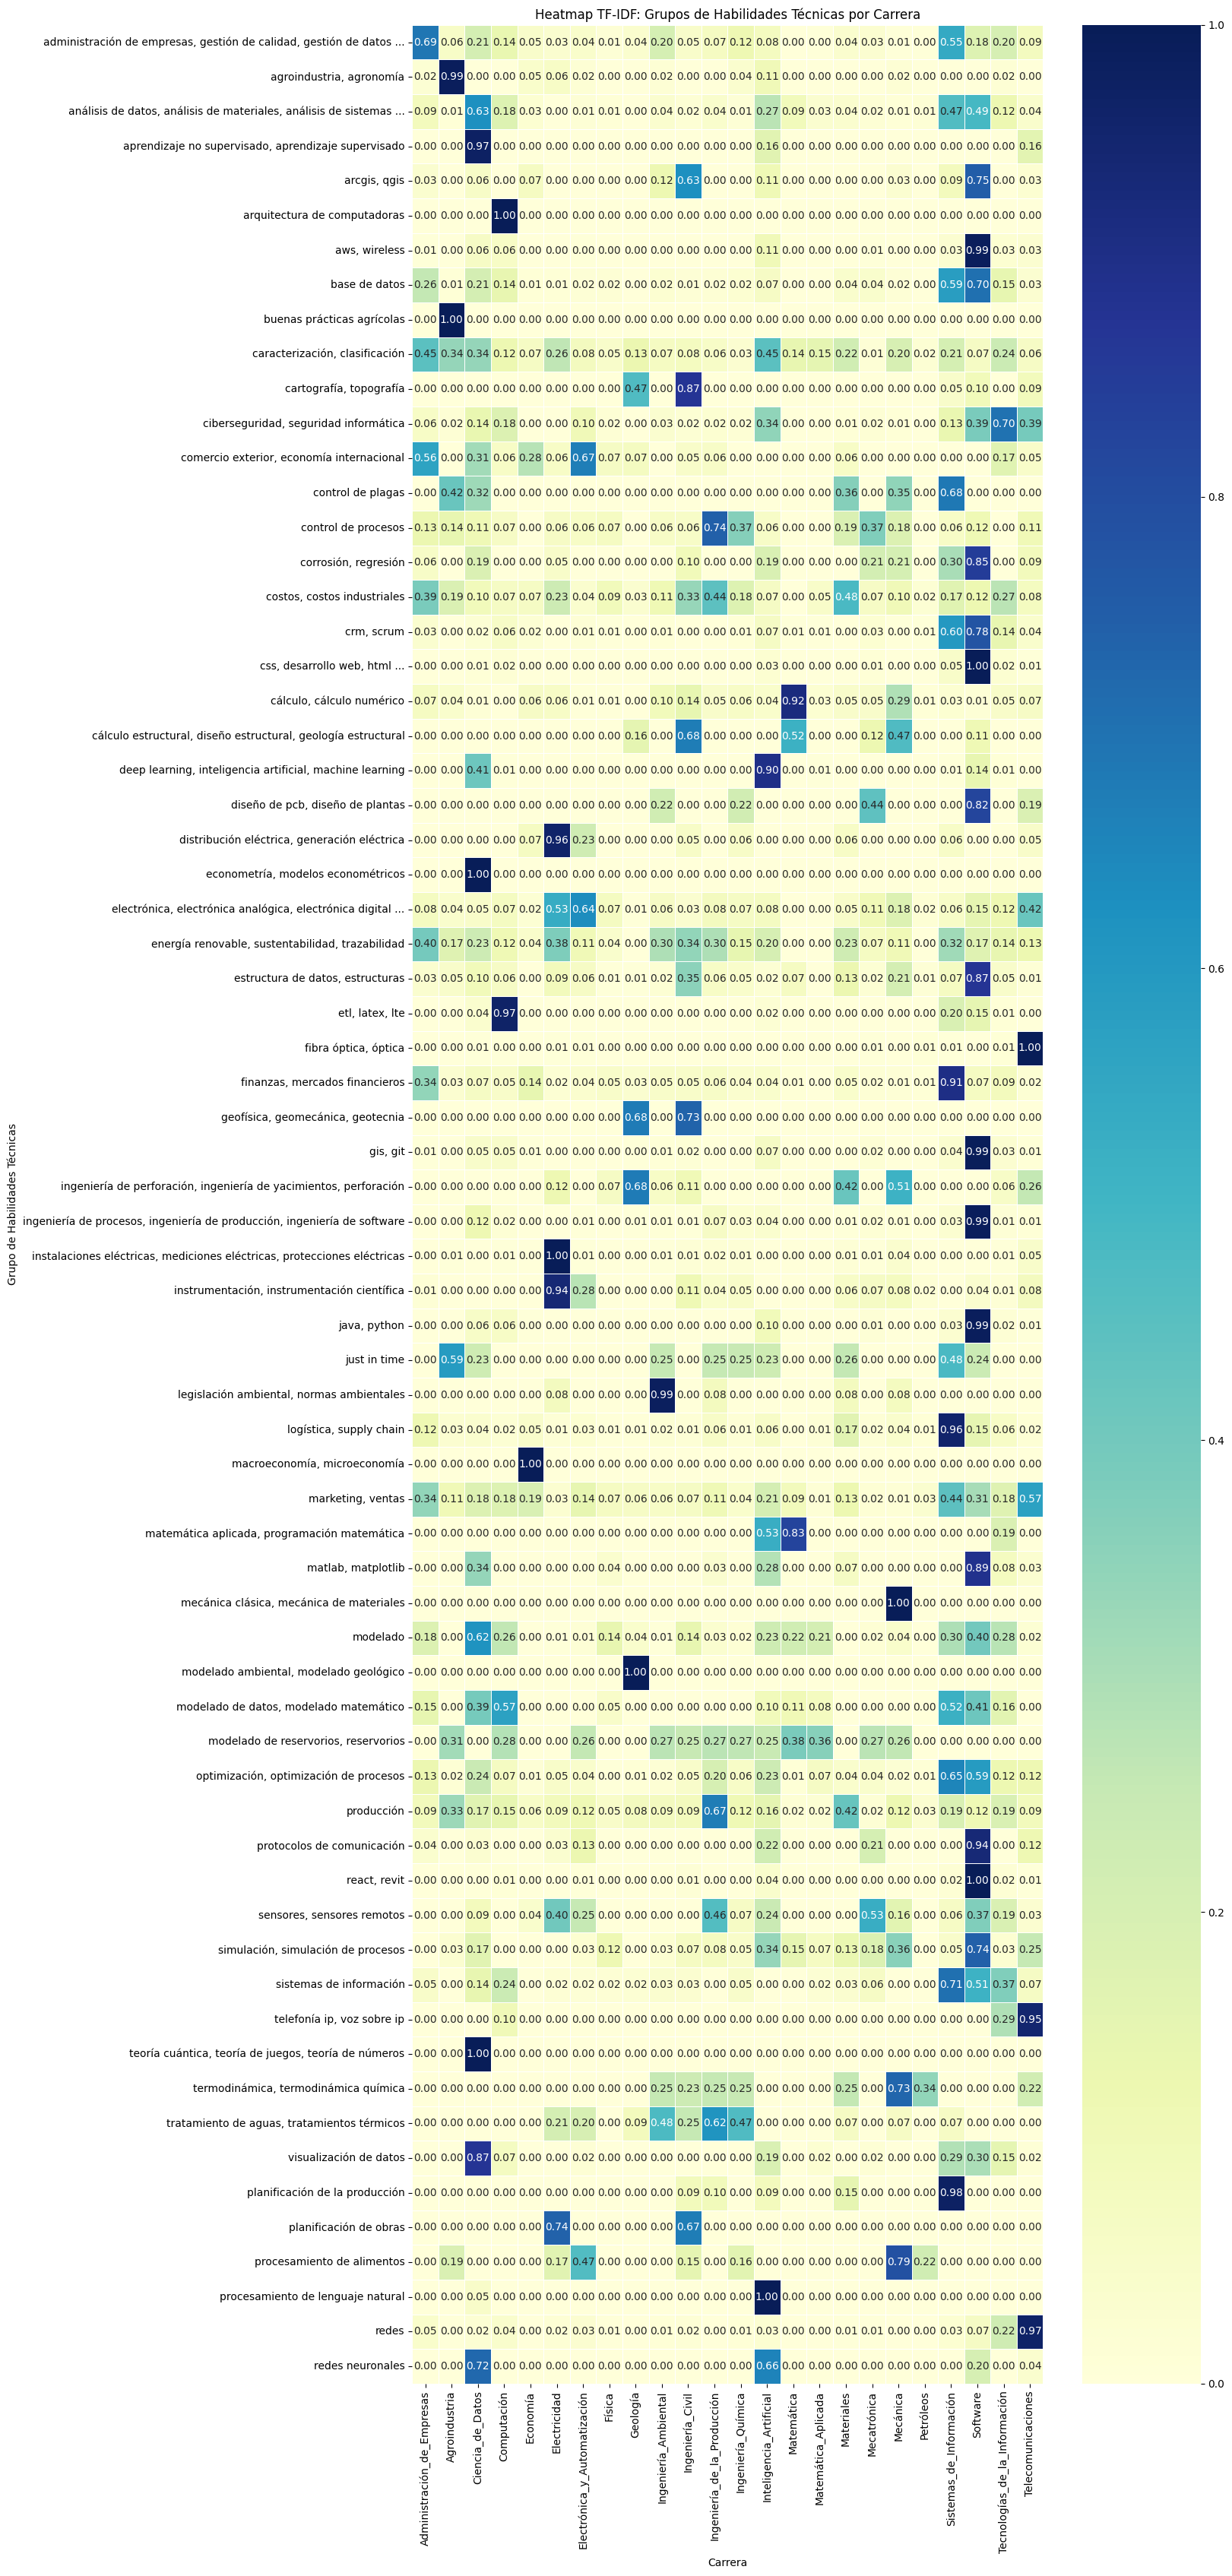

In [2]:
# Heatmap de la matriz TF-IDF por Grupos de Habilidades Técnicas y Carrera
grupos_no_nulos = (tfidf_emb_df.sum(axis=1) > 0)
tfidf_emb_df_filtrado = tfidf_emb_df[grupos_no_nulos]

plt.figure(figsize=(16, max(6, len(tfidf_emb_df_filtrado)*0.5)))
sns.heatmap(tfidf_emb_df_filtrado, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap TF-IDF: Grupos de Habilidades Técnicas por Carrera')
plt.xlabel('Carrera')
plt.ylabel('Grupo de Habilidades Técnicas')
plt.tight_layout()
plt.show()

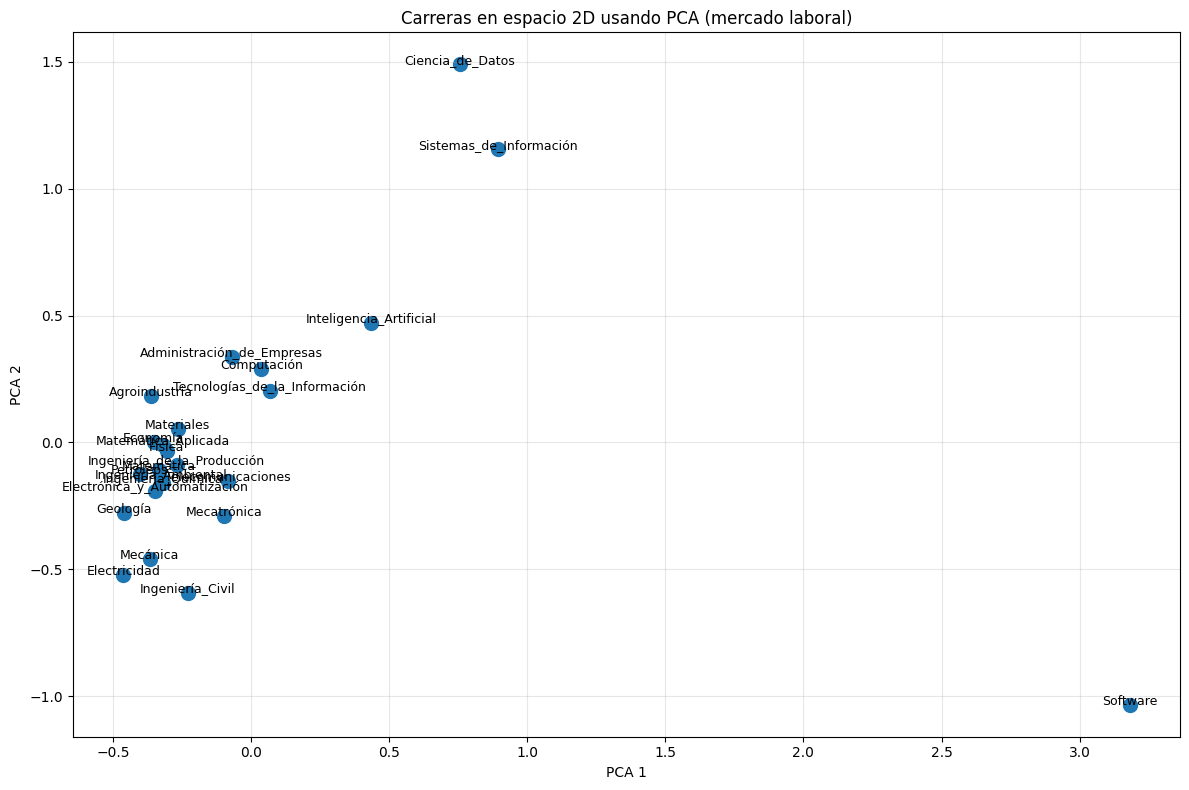

In [3]:
# Visualización PCA de carreras laborales
pca = PCA(n_components=2)
pca_result = pca.fit_transform(espacio_vectorial_tfidf.values)

plt.figure(figsize=(12,8))
plt.scatter(pca_result[:,0], pca_result[:,1], s=100)
for i, carrera in enumerate(espacio_vectorial_tfidf.index):
    plt.text(pca_result[i,0], pca_result[i,1], carrera, fontsize=9, ha='center')
plt.title('Carreras en espacio 2D usando PCA (mercado laboral)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Función de análisis individual por carrera
Función genérica para comparar cualquier carrera académica con su mercado laboral

In [16]:
def analizar_carrera(nombre_academico, nombre_mercado_laboral, ruta_csv):
    """
    Analiza una carrera comparando su perfil académico con ofertas laborales.
    
    Parámetros:
    - nombre_academico: Nombre de la carrera en tfidf_epn_69d (ej: 'Ingenieria En Ciencias De La Computacion')
    - nombre_mercado_laboral: Nombre para el título del gráfico
    - ruta_csv: Ruta al archivo CSV de ofertas (ej: 'todas_las_plataformas/Computación/Computación_Merged.csv')
    """
    print(f"\n{'='*80}")
    print(f"ANÁLISIS: {nombre_mercado_laboral}")
    print(f"{'='*80}\n")
    
    # 1. Vector académico de la carrera
    if nombre_academico not in tfidf_epn_69d.columns:
        print(f"Error: '{nombre_academico}' no encontrado en las carreras académicas.")
        print(f"Carreras disponibles: {list(tfidf_epn_69d.columns)}")
        return None
    
    vector_carrera = tfidf_epn_69d.T.loc[[nombre_academico]]
    
    # 2. Cargar y vectorizar ofertas laborales
    try:
        df_ofertas = pd.read_csv(ruta_csv, dtype=str)
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo '{ruta_csv}'")
        return None
    
    textos_ofertas = df_ofertas[['skills','description']].fillna('').agg(' '.join, axis=1).str.lower().tolist()
    print(f"Ofertas laborales encontradas: {len(textos_ofertas)}")
    
    # Vectorizar
    vectorizer_ofertas = CountVectorizer(vocabulary=habilidades, analyzer='word', ngram_range=(1, 5), lowercase=True)
    X_ofertas = vectorizer_ofertas.transform(textos_ofertas)
    matriz_td_ofertas = pd.DataFrame(X_ofertas.T.toarray(), index=vectorizer_ofertas.get_feature_names_out())
    
    # Agrupar por dimensiones
    matriz_ofertas_69d = pd.DataFrame(0, index=grupos_bge_ngram.keys(), columns=range(len(textos_ofertas)))
    for label, terms in grupos_bge_ngram.items():
        matriz_ofertas_69d.loc[label] = matriz_td_ofertas.loc[terms].sum(axis=0)
    
    matriz_ofertas_69d.index = [', '.join(grupos_bge_ngram[label][:3]) + (' ...' if len(grupos_bge_ngram[label])>3 else '') 
                                 for label in grupos_bge_ngram.keys()]
    
    # TF-IDF
    tfidf_transformer_ofertas = TfidfTransformer(norm='l2').fit(matriz_ofertas_69d.values)
    tfidf_ofertas_69d = pd.DataFrame(
        tfidf_transformer_ofertas.transform(matriz_ofertas_69d.values).toarray(), 
        index=matriz_ofertas_69d.index, 
        columns=matriz_ofertas_69d.columns
    ).T
    
    # 3. PCA
    df_pca = pd.concat([vector_carrera, tfidf_ofertas_69d], ignore_index=True)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_pca.values)
    
    # 4. Calcular distancias
    vector_acad = vector_carrera.values
    vectores_ofertas = tfidf_ofertas_69d.values
    
    distancias_coseno = cosine_distances(vector_acad, vectores_ofertas)[0]
    distancia_promedio_coseno = np.mean(distancias_coseno)
    
    distancias_euclideana = euclidean_distances(vector_acad, vectores_ofertas)[0]
    distancia_promedio_euclideana = np.mean(distancias_euclideana)
    
    print(f"\nMétricas de distancia:")
    print(f"   - Distancia coseno promedio: {distancia_promedio_coseno:.4f}")
    print(f"   - Distancia euclideana promedio: {distancia_promedio_euclideana:.4f}")
    
    # 5. Gráfico PCA
    plt.figure(figsize=(10,6))
    plt.scatter(pca_result[1:,0], pca_result[1:,1], c='blue', label='Ofertas laborales', s=20, alpha=0.5)
    plt.scatter(pca_result[0,0], pca_result[0,1], c='red', label='Carrera (académica)', s=150, marker='*', edgecolors='black', linewidths=1.5)
    plt.legend()
    plt.title(f'PCA: {nombre_mercado_laboral} vs Ofertas laborales (69d)')
    plt.xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return None

## 4. Análisis por carrera

### Computación


ANÁLISIS: Computación

Ofertas laborales encontradas: 4101

Métricas de distancia:
   - Distancia coseno promedio: 0.9895
   - Distancia euclideana promedio: 0.3237

Métricas de distancia:
   - Distancia coseno promedio: 0.9895
   - Distancia euclideana promedio: 0.3237


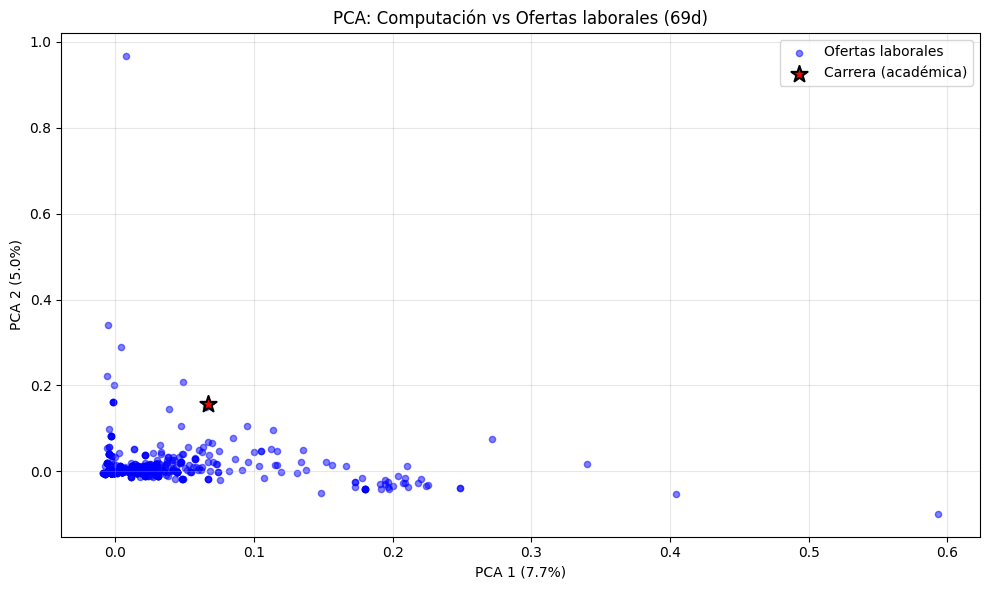

In [17]:
analizar_carrera(
    nombre_academico='Ingenieria En Ciencias De La Computacion',
    nombre_mercado_laboral='Computación',
    ruta_csv='todas_las_plataformas/Computación/Computación_Merged.csv'
 )

### Software


ANÁLISIS: Software

Ofertas laborales encontradas: 5873
Ofertas laborales encontradas: 5873

Métricas de distancia:
   - Distancia coseno promedio: 0.9654
   - Distancia euclideana promedio: 1.1211

Métricas de distancia:
   - Distancia coseno promedio: 0.9654
   - Distancia euclideana promedio: 1.1211


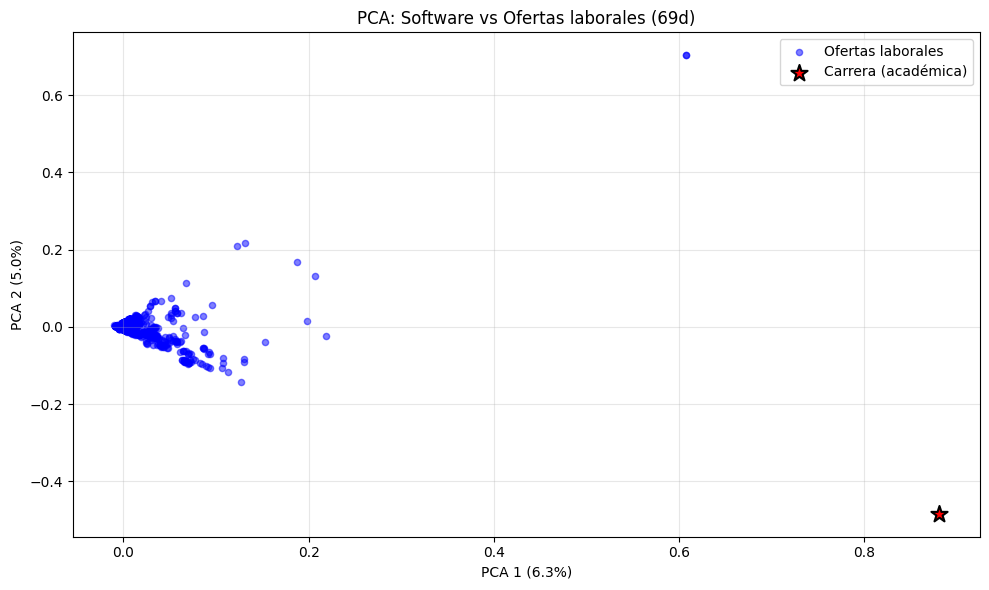

In [6]:
analizar_carrera(
    nombre_academico='Ingenieria En Software',
    nombre_mercado_laboral='Software',
    ruta_csv='todas_las_plataformas/Software/Software_Merged.csv'
 )

### Ciencias de Datos e Inteligencia Artificial


ANÁLISIS: Ciencias de Datos e IA

Ofertas laborales encontradas: 11641
Ofertas laborales encontradas: 11641

Métricas de distancia:
   - Distancia coseno promedio: 0.8753
   - Distancia euclideana promedio: 1.8422

Métricas de distancia:
   - Distancia coseno promedio: 0.8753
   - Distancia euclideana promedio: 1.8422


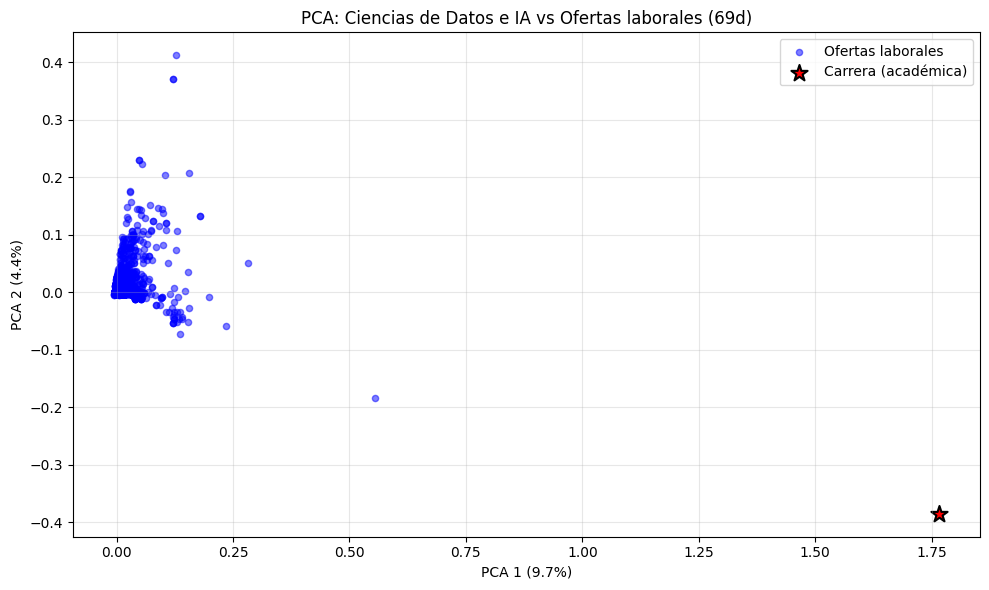

In [19]:
df_ciencia_datos = pd.read_csv('todas_las_plataformas/Ciencia_de_Datos/Ciencia_de_Datos_Merged.csv', dtype=str)
df_ia = pd.read_csv('todas_las_plataformas/Inteligencia_Artificial/Inteligencia_Artificial_Merged.csv', dtype=str)
df_combinado = pd.concat([df_ciencia_datos, df_ia], ignore_index=True)
ruta_combinada = 'temp_ciencia_datos_ia.csv'
df_combinado.to_csv(ruta_combinada, index=False)
analizar_carrera(
    nombre_academico='Ciencias De Datos E Inteligencia Artificial',
    nombre_mercado_laboral='Ciencias de Datos e IA',
    ruta_csv=ruta_combinada
)

### Sistemas de Información


ANÁLISIS: Sistemas de Información

Ofertas laborales encontradas: 6157
Ofertas laborales encontradas: 6157

Métricas de distancia:
   - Distancia coseno promedio: 0.9925
   - Distancia euclideana promedio: 0.9495

Métricas de distancia:
   - Distancia coseno promedio: 0.9925
   - Distancia euclideana promedio: 0.9495


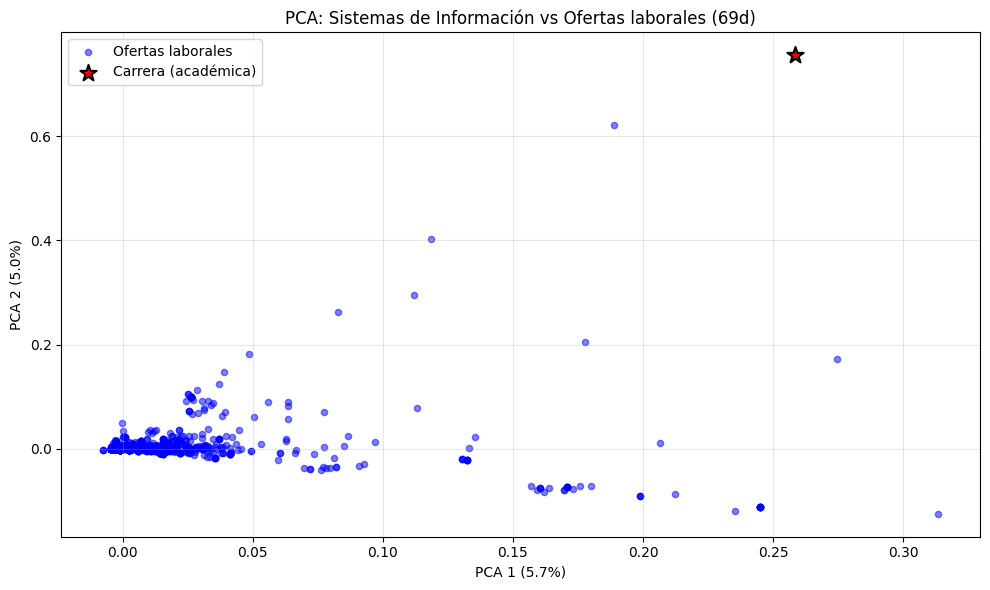

In [8]:
analizar_carrera(
    nombre_academico='Ingenieria En Sistemas De Informacion',
    nombre_mercado_laboral='Sistemas de Información',
    ruta_csv='todas_las_plataformas/Sistemas_de_Información/Sistemas_de_Información_Merged.csv'
 )

### Administración de Empresas


ANÁLISIS: Administración de Empresas

Ofertas laborales encontradas: 5220

Métricas de distancia:
   - Distancia coseno promedio: 0.9799
   - Distancia euclideana promedio: 0.7629

Métricas de distancia:
   - Distancia coseno promedio: 0.9799
   - Distancia euclideana promedio: 0.7629


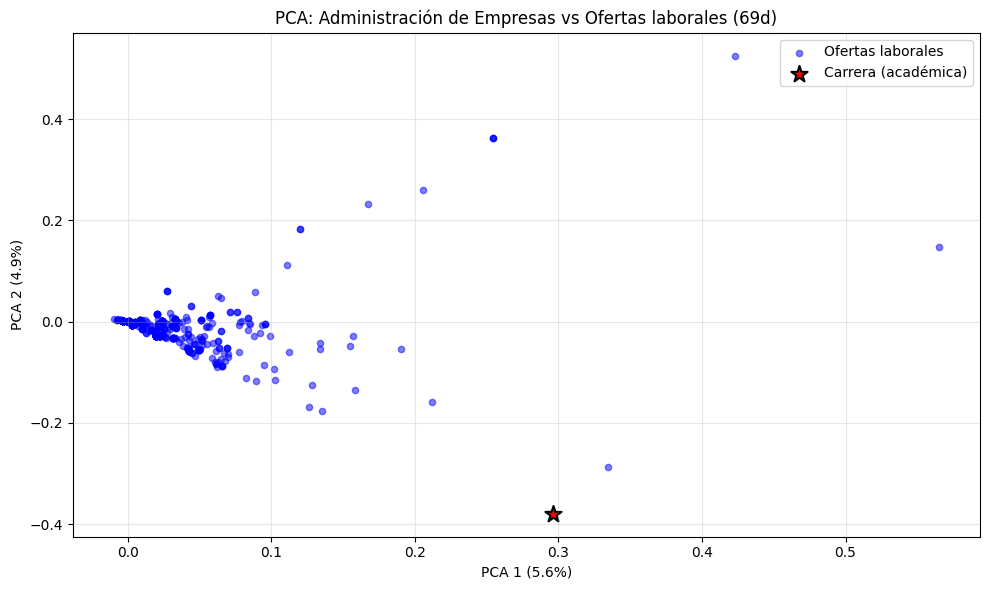

In [9]:
analizar_carrera(
    nombre_academico='Licenciatura Administracion De Empresas',
    nombre_mercado_laboral='Administración de Empresas',
    ruta_csv='todas_las_plataformas/Administración_de_Empresas/Administración_de_Empresas_Merged.csv'
 )

### Agroindustria


ANÁLISIS: Agroindustria

Ofertas laborales encontradas: 1688

Métricas de distancia:
   - Distancia coseno promedio: 0.9867
   - Distancia euclideana promedio: 1.0207

Métricas de distancia:
   - Distancia coseno promedio: 0.9867
   - Distancia euclideana promedio: 1.0207


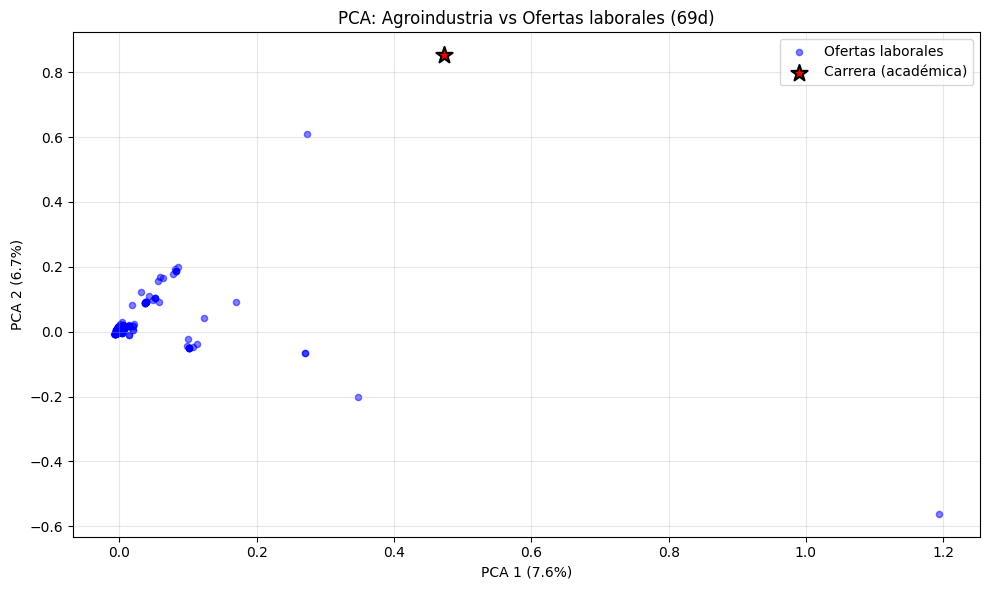

In [10]:
analizar_carrera(
    nombre_academico='Ingenieria Agroindustria',
    nombre_mercado_laboral='Agroindustria',
    ruta_csv='todas_las_plataformas/Agroindustria/Agroindustria_Merged.csv'
 )

### Ambiental


ANÁLISIS: Ambiental

Ofertas laborales encontradas: 3295

Métricas de distancia:
   - Distancia coseno promedio: 0.9986
   - Distancia euclideana promedio: 0.6579

Métricas de distancia:
   - Distancia coseno promedio: 0.9986
   - Distancia euclideana promedio: 0.6579


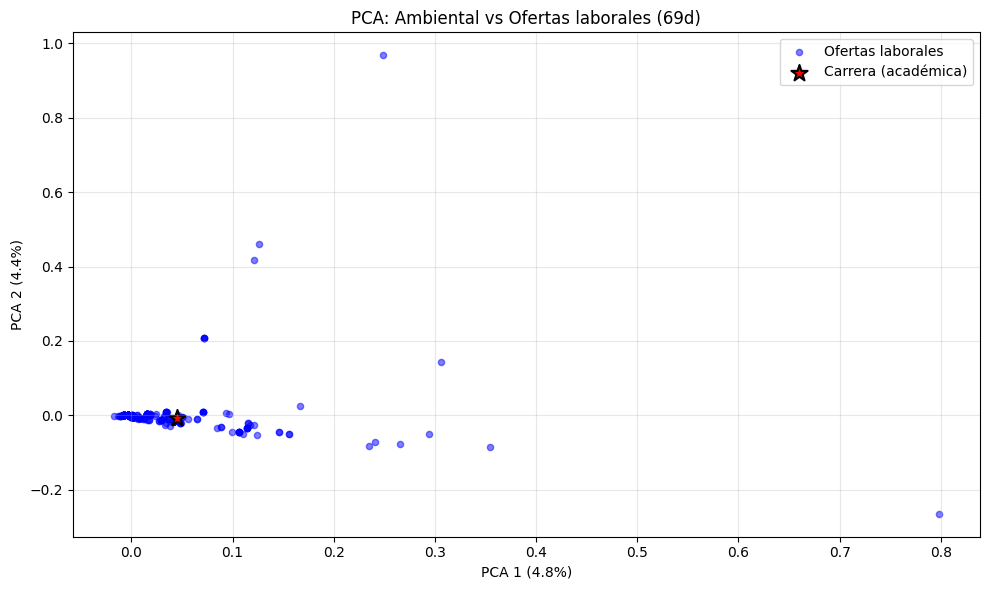

In [20]:
analizar_carrera(
    nombre_academico='Ingenieria Ambiental',
    nombre_mercado_laboral='Ambiental',
    ruta_csv='todas_las_plataformas/Ingeniería_Ambiental/Ingeniería_Ambiental_Merged.csv'
 )

### Economia


ANÁLISIS: Economia

Ofertas laborales encontradas: 2506

Métricas de distancia:
   - Distancia coseno promedio: 1.0000
   - Distancia euclideana promedio: 0.0222

Métricas de distancia:
   - Distancia coseno promedio: 1.0000
   - Distancia euclideana promedio: 0.0222


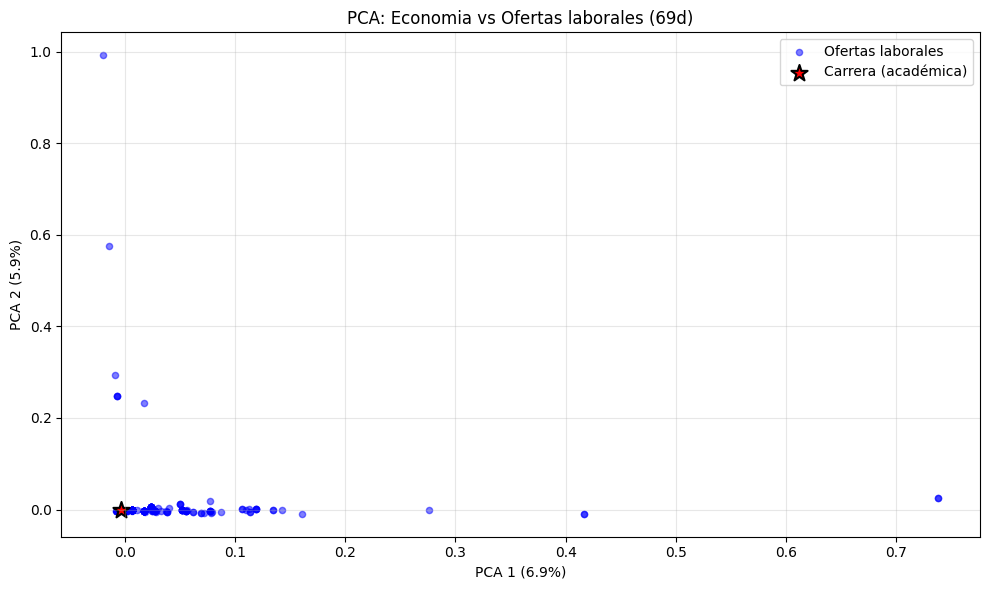

In [22]:
analizar_carrera(
    nombre_academico='Economia',
    nombre_mercado_laboral='Economia',
    ruta_csv='todas_las_plataformas/Economía/Economía_Merged.csv'
 )

### Electricidad


ANÁLISIS: Electricidad

Ofertas laborales encontradas: 2066

Métricas de distancia:
   - Distancia coseno promedio: 0.9712
   - Distancia euclideana promedio: 1.4840

Métricas de distancia:
   - Distancia coseno promedio: 0.9712
   - Distancia euclideana promedio: 1.4840


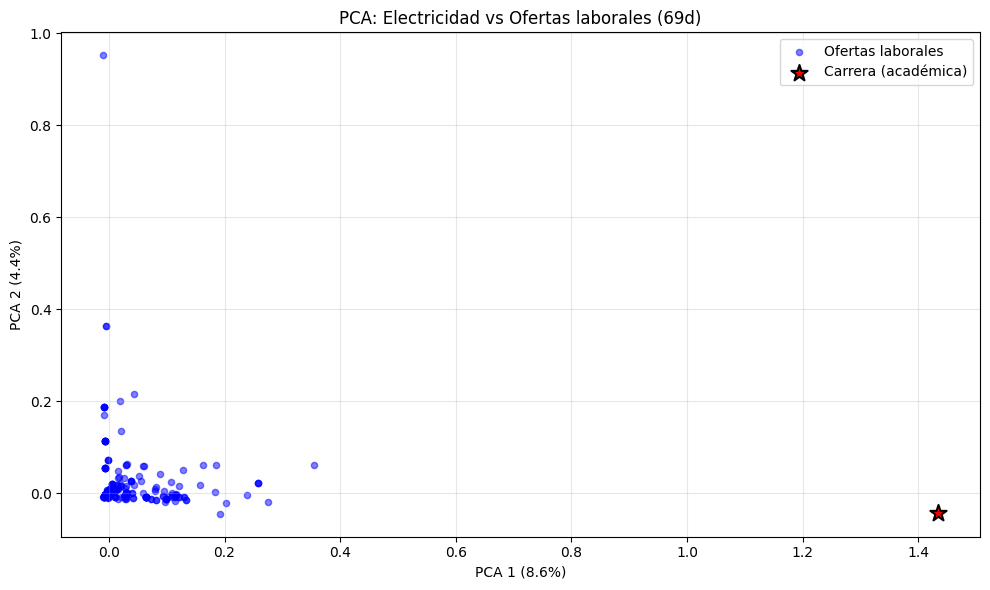

In [23]:
analizar_carrera(
    nombre_academico='Ingenieria En Electricidad',
    nombre_mercado_laboral='Electricidad',
    ruta_csv='todas_las_plataformas/Electricidad/Electricidad_Merged.csv'
 )

### Electrónica Y Automatización


ANÁLISIS: Electrónica Y Automatización

Ofertas laborales encontradas: 6349

Métricas de distancia:
   - Distancia coseno promedio: 0.9866
   - Distancia euclideana promedio: 1.0421

Métricas de distancia:
   - Distancia coseno promedio: 0.9866
   - Distancia euclideana promedio: 1.0421


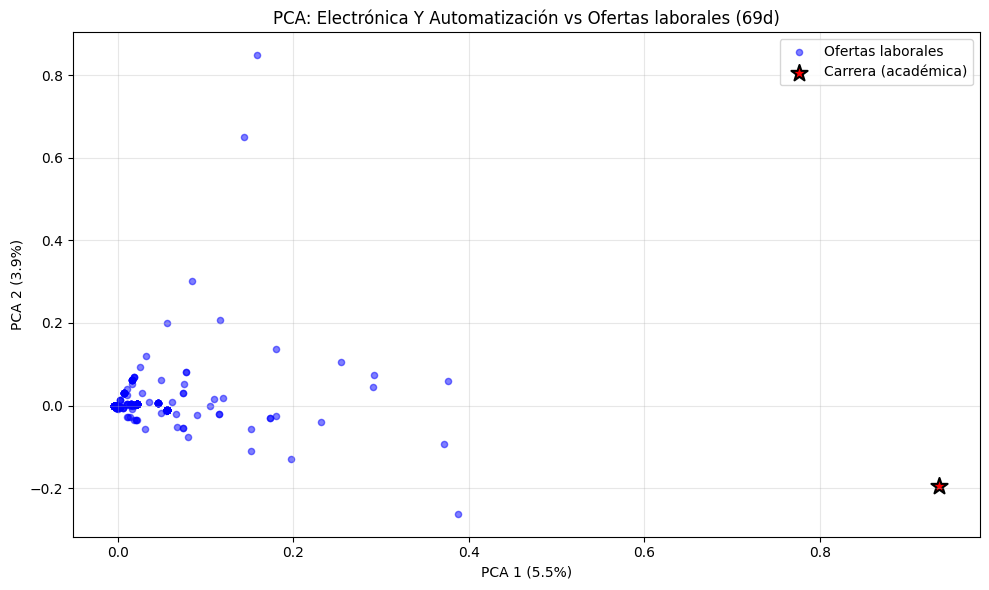

In [26]:
analizar_carrera(
    nombre_academico='Ingenieria En Electronica Y Automatizacion',
    nombre_mercado_laboral='Electrónica Y Automatización',
    ruta_csv='todas_las_plataformas/Electrónica_y_Automatización/Electrónica_y_Automatización_Merged.csv'
 )

### Física


ANÁLISIS: Física

Ofertas laborales encontradas: 1614

Métricas de distancia:
   - Distancia coseno promedio: 0.9996
   - Distancia euclideana promedio: 1.2575

Métricas de distancia:
   - Distancia coseno promedio: 0.9996
   - Distancia euclideana promedio: 1.2575


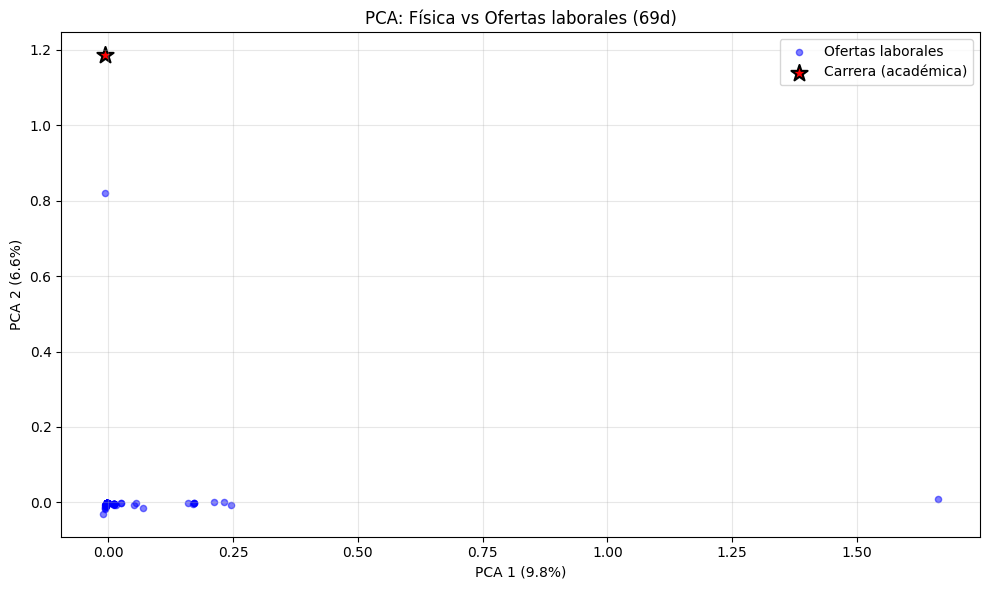

In [27]:
analizar_carrera(
    nombre_academico='Fisica',
    nombre_mercado_laboral='Física',
    ruta_csv='todas_las_plataformas/Física/Física_Merged.csv'
 )